In [1]:
import warnings
warnings.simplefilter('ignore')

In [244]:
import re, json, datetime

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

import plotly.express as px
import plotly.graph_objects as go

In [379]:
futures_params = {
    "Si": {"lot": 1, "xrub": 1},
    "RI": {"lot": 1, "xrub": 1.2},
    "GD": {"lot": 1, "xrub": 60},
    "BR": {"lot": 10, "xrub": 60},
}

In [4]:
def parse_logs(file_name):
    with open(file_name, 'r') as f:
        n_rows = sum(1 for _ in f)
    raw_data = pd.read_json(file_name, orient='records', lines=True, nrows=n_rows-2)
    
    sdate = re.findall("\d{4}-\d{2}-\d{2}", logfile)[0]
    state = raw_data[raw_data['type'] == 'OnTrade']['state']
    info = raw_data[raw_data['type'] == 'OnTrade']['info']

    # Trades
    state = raw_data[raw_data['type'] == 'OnTrade']['state']
    info = raw_data[raw_data['type'] == 'OnTrade']['info']

    trades = pd.DataFrame()
    trades['bid'] = state.apply(lambda x: x[0])
    trades['ask'] = state.apply(lambda x: x[1])
    trades['mid'] = state.apply(lambda x: x[2])
    trades['Q'] = state.apply(lambda x: x[3])
    trades['direction'] = info.apply(lambda x: x['direction'])
    trades['price'] = info.apply(lambda x: x['price'])
    trades.index = pd.to_datetime(sdate + ' ' + raw_data[raw_data['type'] == 'OnTrade']['time'])
    
    # Orders
    orders = pd.DataFrame()
    state = raw_data[raw_data['type'] == 'SetOrder']['state']
    info = raw_data[raw_data['type'] == 'SetOrder']['info']
    
    orders['bid'] = state.apply(lambda x: x[0])
    orders['ask'] = state.apply(lambda x: x[1])
    orders['mid'] = state.apply(lambda x: x[2])
    orders['Q'] = state.apply(lambda x: x[3])
    orders['direction'] = info.apply(lambda x: x['direction'])
    orders['price'] = info.apply(lambda x: x['price'])
    orders.index = pd.to_datetime(sdate + ' ' + raw_data[raw_data['type'] == 'SetOrder']['time'])
    
    # Quotes
    state = raw_data[raw_data['type'] == 'main']['state']
    info = raw_data[raw_data['type'] == 'main']['info']

    quotes = pd.DataFrame()
    quotes['bid'] = state.apply(lambda x: x[0])
    quotes['ask'] = state.apply(lambda x: x[1])
    quotes['mid'] = state.apply(lambda x: x[2])
    quotes['Q'] = state.apply(lambda x: x[3])
    quotes['asm_bid'] = info.apply(lambda x: x['bid'])
    quotes['asm_ask'] = info.apply(lambda x: x['ask'])
    quotes.index = pd.to_datetime(sdate + ' ' + raw_data[raw_data['type'] == 'main']['time'])
    
    return quotes, orders, trades

In [409]:
def Q_PnL(trades, lot=1, xrub=1, commission=0.47):
    df_pnl = pd.DataFrame()
    
    directions = np.where(trades.direction=='B', 1, -1)
    df_pnl['q_pos'] = np.cumsum(directions)
    df_pnl['cash_pos'] = np.cumsum(-directions * trades.price.to_numpy())
    df_pnl['pnl'] = df_pnl['cash_pos'].to_numpy() + df_pnl['q_pos'].to_numpy() * np.where(df_pnl.q_pos>0, trades.bid, trades.ask)
    df_pnl['pnl'] *= lot*xrub
    df_pnl['pnl_net'] = df_pnl['pnl'].to_numpy() - commission*np.arange(1, df_pnl.shape[0]+1)
    
    df_pnl.index = trades.index
    return df_pnl

In [410]:
datetime.timedelta(seconds=1)

datetime.timedelta(seconds=1)

In [461]:
def get_stat(ticker, log_prefix='c:/QUIK-Test/scripts/logs/'):
    date = datetime.datetime.strftime(datetime.date.today(), "%Y-%m-%d")
    file_name = f"{log_prefix}AS-model_{ticker}U2_{date}.log"
    
    quotes, orders, trades = parse_logs(file_name)
    counts = orders['Q'].rolling(window=datetime.timedelta(seconds=1)).count()    
    
    pnl = Q_PnL(trades, lot=futures_params[ticker]["lot"], 
            xrub=futures_params[ticker]["xrub"], 
            commission=0.47)
    
    return pnl['pnl'][-1], pnl['pnl_net'][-1], pnl.shape[0], np.max(counts)

In [494]:
# Monitoring
for ticker in futures_params:
    pnl_gross, pnl_net, pnl_count, max_cnt = get_stat(ticker)
    print(f"{ticker}\t{pnl_count:d}\t{pnl_gross:0.1f}\t{pnl_gross/pnl_count:0.2f}\t{pnl_net:0.1f}\t{max_cnt:.0f}")

Si	7579	7430.0	0.98	3867.9	4
RI	1986	9744.0	4.91	8810.6	4
GD	974	3756.0	3.86	3298.2	3
BR	464	1644.0	3.54	1425.9	3


In [504]:
ticker = "BR"
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}U2_2022-08-26.log"

quotes, orders, trades = parse_logs(logfile)
counts = orders['Q'].rolling(window=datetime.timedelta(seconds=1)).count() * 2

In [505]:
pnl = Q_PnL(trades, lot=futures_params[ticker]["lot"], 
            xrub=futures_params[ticker]["xrub"], 
            commission=0.47)

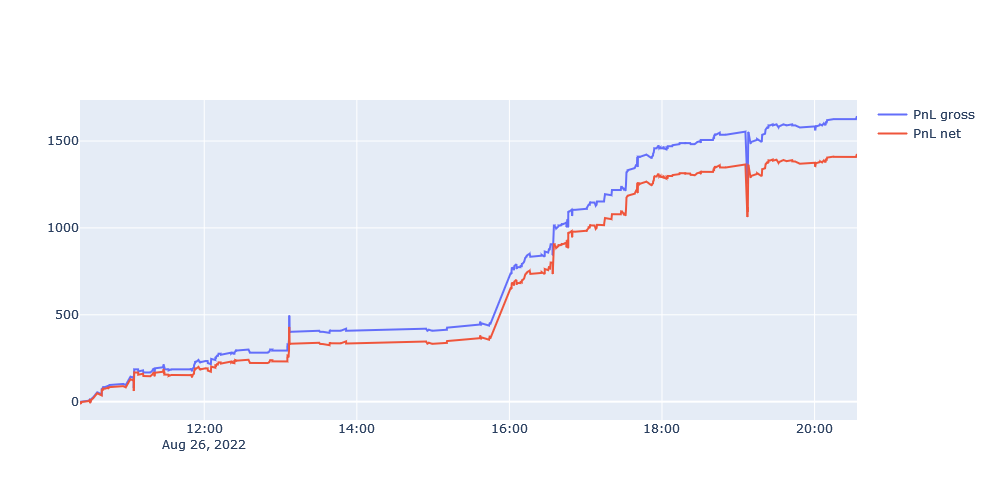

In [506]:
# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=pnl.index, y=pnl.pnl,
                    mode='lines',
                    name='PnL gross'))
fig.add_trace(go.Scatter(x=pnl.index, y=pnl.pnl_net,
                    mode='lines',
                    name='PnL net'))

fig.update_layout(width=1000, height=500)

fig.show()

In [435]:
ticker = "Si"
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}U2_2022-08-26.log"
quotes, orders, trades = parse_logs(logfile)
countsSi = orders['Q'].rolling(window=datetime.timedelta(seconds=1)).count() * 2

ticker = "RI"
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}U2_2022-08-26.log"
quotes, orders, trades = parse_logs(logfile)
countsRI = orders['Q'].rolling(window=datetime.timedelta(seconds=1)).count() * 2

ticker = "GD"
logfile = f"c:/QUIK-Test/scripts/logs/AS-model_{ticker}U2_2022-08-26.log"
quotes, orders, trades = parse_logs(logfile)
countsGD = orders['Q'].rolling(window=datetime.timedelta(seconds=1)).count() * 2

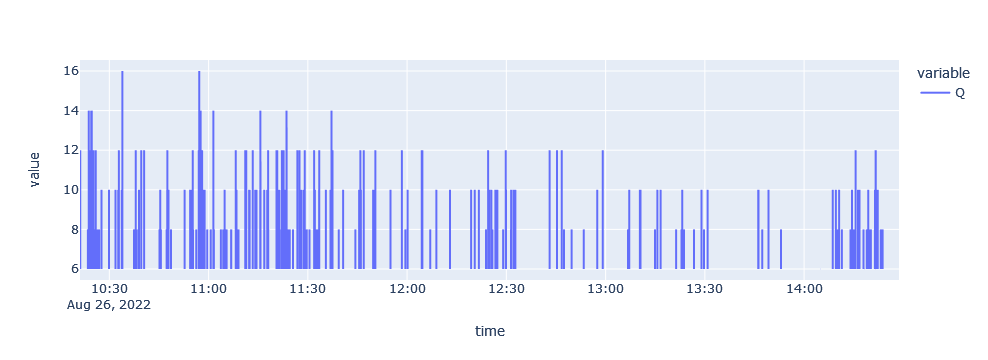

In [436]:
px.line(countsSi+countsRI+countsGD)

In [458]:
ticker = "GD"
logfile = f"c:/OpenQIUK/scripts/logs/AS-model_{ticker}U2_2022-08-26.log"

quotes, orders, trades = parse_logs(logfile)
counts = orders['Q'].rolling(window=datetime.timedelta(seconds=1)).count() * 2

In [459]:
pnl = Q_PnL(trades, lot=futures_params[ticker]["lot"], 
            xrub=futures_params[ticker]["xrub"], 
            commission=0.47)

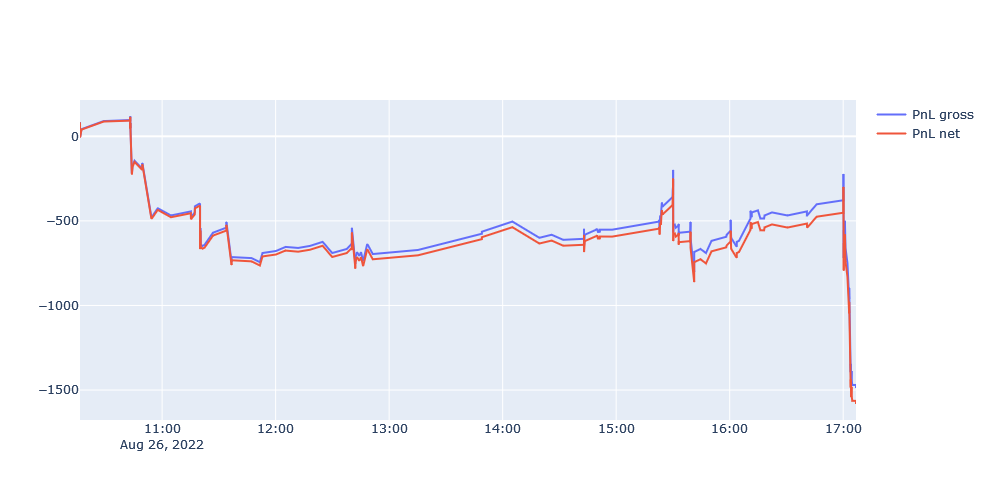

In [460]:
# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=pnl.index, y=pnl.pnl,
                    mode='lines',
                    name='PnL gross'))
fig.add_trace(go.Scatter(x=pnl.index, y=pnl.pnl_net,
                    mode='lines',
                    name='PnL net'))

fig.update_layout(width=1000, height=500)

fig.show()